# Starbucks Twitter Data NLP - Sentiment Analysis, Topic Modeling, Visualization


## Nathan Murstein 

Motivation: 

In today's world, focus groups, consumer panels, and surveys are no longer the most efficient way for companies to gauge their customers' opinions and thoughts about their brand. Whether it is to influence product design, branding strategy, identify trends, or stay on top of potential PR crises, "listening in" on social media is a must. Automating a pipeline to retrieve and analyze this data, and using machine learning to mine actionable insights from social media can allow corporate strategy to be based on data and direct customer feedback.

Challenge: 

Despite the above benefits, social media data is very messy and contains a lot of noise that can obstruct the most important insights. In this notebook, I will show how to succesfully use NLP techniques to extract these useful insights from Twitter data, using the use case of the coffee industry and the Starbucks brand.

Dataset: 

I am using a dataset scraped from Twitter (using Twint) for tweets between March 25 - April 25 2020 that contain the keywords 'Starbucks' and/or 'Coffee'. During this time, a very popular coffee trend emerged on Tik Tok, known as Dalgona Coffee (https://en.wikipedia.org/wiki/Dalgona_coffee). A succesful analysis using the data sample for this time should identify this as a coffee trend that Starbucks did not take advantage of.

First, let's load and examine the dataset. Notice that each row represents one tweet, and the keyword for each row is either starbucks or coffee. I will explain why we are looking at tweets for coffee - rather than just starbucks - later. We have 63575 rows.

In [199]:
import pandas as pd
starbucks_tweets = pd.read_csv('Dalgona_mar20_may20.csv')
starbucks_tweets.head()

C:\Users\Nathan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning:

Columns (0,1,2,3,11,12,15,20,22,26,32) have mixed types.Specify dtype option on import or set low_memory=False.



,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,...,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,keyword,group,year,month
0,0,1234267171175444481,1234267171175444481,1.58311e+12,2020-03-01 15:59:59,-700.0,NaN,"¿Te gusta el café? ¡Este mes, le daremos a un ...",es,[],...,NaN,[],NaN,NaN,NaN,NaN,Starbucks,1.0,2020.0,3.0
1,1,1234267170693095424,1234267170693095424,1.58311e+12,2020-03-01 15:59:59,-700.0,NaN,"Do you like coffee? This month, we will be gi...",en,[],...,NaN,[],NaN,NaN,NaN,NaN,Starbucks,1.0,2020.0,3.0
2,2,1234267148777816064,1234267148777816064,1.58311e+12,2020-03-01 15:59:54,-700.0,"{'type': 'Point', 'coordinates': [33.97794752,...","I'm at Starbucks in Mira Loma, CA https://t.c...",en,[],...,NaN,[],NaN,NaN,NaN,NaN,Starbucks,1.0,2020.0,3.0
3,3,1234267143165771776,1234266590150979584,1.58311e+12,2020-03-01 15:59:53,-700.0,NaN,Starbucks cups. Love the mobile order. Have be...,en,[],...,NaN,[],NaN,NaN,NaN,NaN,Starbucks,1.0,2020.0,3.0
4,4,1234267125918752768,1234214183018942467,1.58311e+12,2020-03-01 15:59:49,-700.0,NaN,@heyRJ7 Just to see you!,en,[],...,NaN,"[{'screen_name': 'heyRJ7', 'name': 'RJ 🧙\u200d...",NaN,NaN,NaN,NaN,Starbucks,1.0,2020.0,3.0


Now, let's filter the date range we want and save the sample into a csv file:

In [200]:
#import datetime
starbucks_tweets['date'] = pd.to_datetime(starbucks_tweets['date'],format='%Y-%m-%d',errors='coerce')

In [ ]:
start_date = pd.Timestamp(2020,3,24)
end_date = pd.Timestamp(2020,4,26)
filter_mask = (starbucks_tweets['date'] > start_date) & (starbucks_tweets['date'] < end_date)
filtered_df = starbucks_tweets[filter_mask]
filtered_df.to_csv('dalgona_sbux.csv', index=False)

**1. Preprocessing/Cleaning**

As we can see, the 'tweet' column contains various langiages, non-alphanumeric characters, missing values, and emojis that make it impossible to analyze.

Therefore, we must define a function to clean the tweets column and return the dataframe with the tweets in an analyzable form.

We will:
> 1) remove non-alphabetical characters <br>
2) drop rows with empty tweet columns<br>
3) eliminate stopwords - both common english stopwords and use-case specific <br>
3) remove any encoding from words<br>
4) lemmatize the words (strip them down to their root form)

In [205]:
def preprocess(csv_name, english_only = True):
  '''
  Preprocesses the tweet column in a data frame and returns the dataframe with a cleaned tweets column. 
  Parameters:
    -csv_name: a csv file with tweet data (must have 'tweet' column)
    -english_only = filters non-english tweets if True, defaults to True
  '''
  import langid
  from nltk.corpus import stopwords
  from nltk import download
  download('wordnet')
  from nltk.stem import WordNetLemmatizer
  import re
  import pandas as pd

  #df = dataframe.copy()
  df = pd.read_csv(csv_name)
  #replace non-alphabetical characters with space using Regex
  df['tweet'] = df['tweet'].map(lambda x: re.sub(r'[^a-zA-Z] ', ' ', str(x)))
  #eliminate rows with empty values for tweet by dropping na's
  df = df.dropna(subset=['tweet'])
  #stopwords - NLTK
  download('stopwords')
  #additional stopwords based on previous wordcloud results
  more_stopwords = ["starbucks","want", "coffee", "like", "say", "put" , "nestl", "nestle", "nestlé", "starbuck", "starbucks", "https", "cc", "co", "ht", "tps", "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the","Mr", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
  stop = stopwords.words('english') + more_stopwords
  # define function to remove encoding of word- strip off any unwanted formatting
  def remove_encoding_word(word):
      word = str(word)
      word = word.encode('ASCII', 'ignore').decode('ASCII')
      return word
  # define function to apply remove_encoding_word to each word in text
  def remove_encoding_text(text):
      text = str(text)
      text = ' '.join(remove_encoding_word(word) for word in text.split() if word not in stop)
      return text
  # apply remove_encoding_text to tweet, lemmatize words, make lowercase
  df['tweet'] = df['tweet'].apply(remove_encoding_text)
  text = ' '.join(words for words in df['tweet'])
  lemma = WordNetLemmatizer().lemmatize
  def cleanup(document):
    tokens = [lemma(w).lower() for w in document.split() if len(w) > 3 and w.isalpha()]
    text = ' '.join(tokens)
    return text
  df['tweet'] = df['tweet'].apply(cleanup)
  # filter only English tweets
  df = df[df['tweet'] != '']
  if english_only == True:
    df['Language'] = df['tweet'].apply(lambda x: langid.classify(x))
    df = df.loc[df['language'] == 'en']
  return df

Now, we apply this funtion to the data. As you can see below, the tweet columns now contain words in an easily analyzable format, without missing values or special characters.

In [206]:
#preprocessed_dalgona = preprocess('/content/drive/MyDrive/Dalgona_mar20_may20.csv')
preprocessed_dalgona = preprocess('dalgona_sbux.csv')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nathan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\Nathan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning:

Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nathan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [207]:
preprocessed_dalgona.head()

,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,...,reply_to,retweet_date,translate,trans_src,trans_dest,keyword,group,year,month,Language
0,0,1.242602e+18,1.242595e+18,1.585094e+12,2020-03-24 16:59:50,-700.0,NaN,starbucks closed gift card something,en,[],...,"[{'screen_name': 'ochocinco', 'name': 'Chad Jo...",NaN,NaN,NaN,NaN,Starbucks,24.0,2020.0,3.0,"(en, -33.40724468231201)"
1,1,1.242602e+18,1.242602e+18,1.585094e+12,2020-03-24 16:59:45,-700.0,NaN,work amazing company shoutout starbucks making...,en,[],...,[],NaN,NaN,NaN,NaN,Starbucks,24.0,2020.0,3.0,"(en, -117.3862886428833)"
2,2,1.242602e+18,1.242602e+18,1.585094e+12,2020-03-24 16:59:40,-700.0,NaN,miss,en,[],...,[],NaN,NaN,NaN,NaN,Starbucks,24.0,2020.0,3.0,"(en, 9.061840057373047)"
3,3,1.242602e+18,1.242568e+18,1.585094e+12,2020-03-24 16:59:28,-700.0,NaN,take,en,[],...,"[{'screen_name': 'mazeofminho', 'name': 'aiiyl...",NaN,NaN,NaN,NaN,Starbucks,24.0,2020.0,3.0,"(en, 9.061840057373047)"
4,4,1.242602e+18,1.242602e+18,1.585094e+12,2020-03-24 16:58:57,-700.0,NaN,making really whats carrying since every brook...,en,[],...,[],NaN,NaN,NaN,NaN,Starbucks,24.0,2020.0,3.0,"(en, -85.69398403167725)"


In [213]:
#dump preprocessed data into pickle
import pickle
with open('preprocessed_dalgona.pickle', 'wb') as handle:
    pickle.dump(preprocessed_dalgona, handle, protocol=pickle.HIGHEST_PROTOCOL)

**2. Sentiment Analysis**

Let's see if Twitter users who tweeted about Starbucks during this time period had positive or negative things to say.

In [232]:
with open('preprocessed_dalgona.pickle', 'rb') as handle:
    preprocessed_dalgona = pickle.load(handle)

#split data into tweets with the 'starbucks' keyword and tweets with the 'coffee' keyword. This will be ore useful later.
dalgona_preprocessed_kwd_sbucks = preprocessed_dalgona[preprocessed_dalgona['keyword'] == 'Starbucks']
dalgona_preprocessed_kwd_coffee = preprocessed_dalgona[preprocessed_dalgona['keyword'] == 'Coffee']

In [262]:
#define function to graph sentiments of tweets
def sentiment_graph(df1, english_only = True):
  ''''
  Takes a dataframe with tweets and plots a bar chart of the counts of postitive vs negative tweets.
  Parameters:
    -df1: a preprocessed dataframe with a 'tweets' column
    -english_only = filters non-english tweets if True, defaults to True
  '''
  import plotly.express as px
  from textblob import TextBlob
  import pandas as pd
  import plotly
  from  plotly.offline import plot
  from plotly.offline import iplot
  import plotly.graph_objects as go
  from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot
  init_notebook_mode(connected=True)

  # add seniment column to dataframe, fill with sentiment for tweet in each row
  def fetch_sentiment_using_textblob(text):
        sentiment = []
        for i in text: 
          analysis = TextBlob(i)
          # set sentiment 
          if analysis.sentiment.polarity >= 0:
              sentiment.append('positive')
          elif analysis.sentiment.polarity == 0:
              sentiment.append('neutral')
          else: 
              sentiment.append('negative')
        return sentiment
  tweet = df1['tweet']
  # add seniment column to dataframe, fill with sentiment for tweet in each row
  df1['sentiment']= fetch_sentiment_using_textblob(tweet)
  # to graph the sentiments, we first group by each sentiment category and count the amount of tweets in each
  df1 = df1.groupby(["sentiment"]).count().reset_index()
  # create graph
  fig = go.Figure(data=[go.Bar(
            x=df1['sentiment'], y=df1['id'],
            text=df1['id'],
            textposition='auto',
        )])
  fig.show()

Now let's apply this function to our preprocessed data:

In [263]:
#graph sentiment proportions of starbucks tweets
sentiment_graph(dalgona_preprocessed_kwd_sbucks)

<ipython-input-262-cd063d8c8aa9>:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We see that 83.47% of tweets are positive. Later, we can look at what topics the positive tweets contained, and what themes existed across negative tweets.

**3. Topic Modeling**

Now that we have preprocessed tweets and looked at the sentiment, we want to understand the specific topics that were popular in the data. This can be helpful for Starbucks to understand specific trends that drive positive or negative sentiment, and inform marketing and product design strategy.

We will use Latent Dirichlet Allocation (LDA), a type of topic model, to classify the text. We will then visualize the topics and see if they are positive or negative. I explain the implementation steps below, but for a more detailed explanation of the algorithm, I reccomend this article:https://towardsdatascience.com/lda-topic-modeling-an-explanation-e184c90aadcd

In [219]:
def topics(df1, english_only = True):
  '''
  Takes a dataframe with tweets and extracts topics. Prints top 10 topics and plots four wordclouds for the top four topics. 
  Parameters:
    -df: a preprocessed dataframe with a 'tweets' column
    -english_only = filters non-english tweets if True, defaults to True
  '''
  from nltk import download
  download('wordnet')
  from nltk.stem import WordNetLemmatizer
  from sklearn.decomposition import LatentDirichletAllocation
  import matplotlib.pyplot as plt
  import pandas as pd
  from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
  from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
  import plotly.graph_objects as go
  from pandas import DataFrame
  from textblob import TextBlob
  
  # Storing the entire text in a list
  text = list(df1.tweet.values)
  #There is no built-in lemmatizer in the Sklearn vectorizer so we extend the CountVectorizer class by overwriting the "build_analyzer" method as follows to add a lemmatizer:
  lemm = WordNetLemmatizer()
  class LemmaCountVectorizer(CountVectorizer):
      def build_analyzer(self):
          analyzer = super(LemmaCountVectorizer, self).build_analyzer()
          return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))
  # Calling our overwritten Count vectorizer on text
  tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
  tf = tf_vectorizer.fit_transform(text)
  
  #create an LDA instance through the Sklearn's LatentDirichletAllocation function
  lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                  learning_method = 'online',
                                  learning_offset = 50.,
                                  random_state = 0) 
  #fit LDA model
  lda.fit(tf)

  # Define helper function to print top words
  topics = []
  def print_top_words(model, feature_names, n_top_words):
      for index, topic in enumerate(model.components_):
          message = " ".join([(feature_names[i] + ',') for i in topic.argsort()[:-n_top_words - 1 :-1]])
          message = message[0:(len(message) - 1)]
          topics.append(message)

  #print top words for each topic
  n_top_words = 20
  print("\nTopics in LDA model: ")
  tf_feature_names = tf_vectorizer.get_feature_names()
  print_top_words(lda, tf_feature_names, n_top_words)

  #get sentiments for each topic
  def fetch_sentiment_using_textblob(text):
        sentiment = []
        for i in text: 
          analysis = TextBlob(i)
          # set sentiment 
          if analysis.sentiment.polarity >= 0:
              sentiment.append('positive')
          elif analysis.sentiment.polarity == 0:
              sentiment.append('neutral')
          else: 
              sentiment.append('negative')
        return sentiment
  topics_df = DataFrame(topics, columns = ['topic'])
  sentiments = []
  for topic in topics_df['topic']:
    sentiments.append(fetch_sentiment_using_textblob(topics_df))
  

#create table for topics
  fig = go.Figure(data=[go.Table(header=dict(values=['Topics (by rank)', 'Top Words in Topic', 'Topic Sentiment']),
                 cells=dict(values=[[('Topic ' + str(i)) for i in range(1,11)],topics, sentiments]))
                     ])
  fig.update_layout(width=700, height=700)
  fig.show()

  #Word Cloud visualizations of the topics
  first_topic = lda.components_[0]
  second_topic = lda.components_[1]
  third_topic = lda.components_[2]
  fourth_topic = lda.components_[3]

  first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
  second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
  third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
  fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

  
  for  i, topic in enumerate([first_topic_words, second_topic_words, third_topic_words, fourth_topic_words], start=1):
    cloud = WordCloud(
                            stopwords=STOPWORDS,
                            background_color='black',
                            width=2500,
                            height=1800
                          ).generate(" ".join(topic))
    plt.imshow(cloud)
    plt.title("Topic " + str(i))
    plt.axis('off')
    plt.show()

Now, let's apply this function to our Starbucks data and view the topics:

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nathan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Topics in LDA model: 


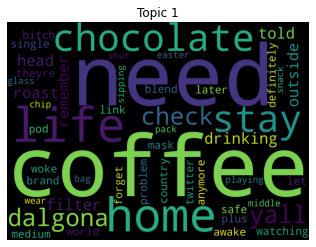

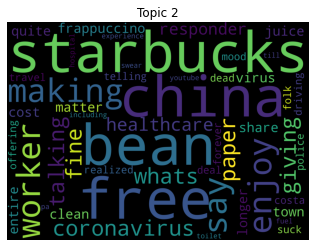

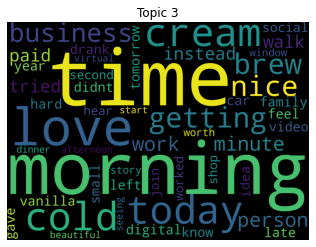

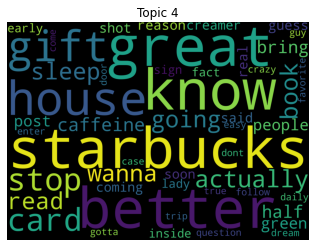

In [212]:
topics(preprocessed_dalgona)

As you can see, the topic modeling analysis identified dalgona as a keyword in the first topic. This is rather unusual and would not have been the case for any other time than the specific date range we are using as a sample.

**Top Words**

Now, let's examine what the top words were in tweets mentioning our keyword. First, we define a function to graph the top words given the csv file of tweets.

In [237]:
def top_words_graph(df1, english_only = True):
  '''
  Takes dataframe with tweets and plots top words by frequency.
  Parameters:
    -df1: a preprocessed dataframe with a 'tweets' column
    -english_only = filters non-english tweets if True, defaults to True
  '''
  import numpy as np
  from nltk import download
  download('wordnet')
  from nltk.stem import WordNetLemmatizer
  import matplotlib.pyplot as plt
  import pandas as pd
  from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
  #!pip install plotly
  import plotly
  from  plotly.offline import plot
  from plotly.offline import iplot
  import plotly.graph_objects as go

  #handle empty df case:
  if df1.empty:
    data = [go.Bar(
            x = [0 for i in range(11)],
            y = [0 for i in range(11)],
            marker= dict(colorscale='Jet'
                        ),
            text='Word counts'
           )]

    layout = go.Layout(
      title='Top 50 Word frequencies'
    )

    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig, filename='basic-bar')
    return

  # Storing the entire text in a list
  text = list(df1.tweet.values)
  #There is no built-in lemmatizer in the Sklearn vectorizer so we extend the CountVectorizer class by overwriting the "build_analyzer" method as follows to add a lemmatizer:
  lemm = WordNetLemmatizer()
  class LemmaCountVectorizer(CountVectorizer):
      def build_analyzer(self):
          analyzer = super(LemmaCountVectorizer, self).build_analyzer()
          return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))
  # Calling our overwritten Count vectorizer on text
  tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
  tf = tf_vectorizer.fit_transform(text)
  feature_names = tf_vectorizer.get_feature_names()
  count_vec = np.asarray(tf.sum(axis=0)).ravel()
  zipped = list(zip(feature_names, count_vec))
  x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))
  # Now I want to extract out on the top 15 and bottom 15 words
  Y = np.concatenate([y[0:15], y[-16:-1]])
  X = np.concatenate([x[0:15], x[-16:-1]])
  
  #plot
  data = [go.Bar(
              x = x[0:10],
              y = y[0:10],
              marker= dict(colorscale='Jet',
                          color = y[0:50]
                          ),
              text='Word counts'
      )]

  layout = go.Layout(
      title='Top 50 Word frequencies'
  )

  fig = go.Figure(data=data, layout=layout)

  plotly.offline.iplot(fig, filename='basic-bar')
  # if you want to save a static image of the graph
  # fig.write_image("top_words.png")

Now, let's apply this function and view the top words:

In [240]:
top_words_graph(dalgona_preprocessed_kwd_sbucks)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nathan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Wordcloud**

Finally, another usefull visualization is a word cloud. 

We will use TF-IDF, rather than word frequency, to rank words so that we see the most relevant words. We obtain TF-IDF weights for each word by multiplying it's frequency in each tweet, and the inverse frequency of the word across all the tweets. 

Another complication is that  if we are using this to visualize a word cloud for a specific brand, such as Starbucks, we want to see the specific topics and words that are relevant to Starbucks, not just the coffee industry as a whole. For example, the word 'coffee' will have a high TF-IDF weight, but is not interestingly unique to Starbucks. Therefore, we include an optional parameter to supply 'baseline' data, such as data for tweets with the keyword 'coffee'. We do this by dividing the TF-IDF score for each word in the 'Starbucks' keyword tweets by the TF-IDF score for the same word in the 'Coffee' keyword tweets. The larger the differnce, the greater the rescaled TF-IDF will be, and we will end up seeing the words that are most relevant and distinct for Starbucks' specific brand. 

In [241]:
def create_wordcloud(df1, mask_png = None, baseline = None):
  '''
    df1: a preprocessed dataframe with a 'tweets' column
    mask_png(optional): a png of the logo to use as the coloring scheme
    baseline(optional): a preprocessed dataframe (competitors or overall category) to compare starbucks word frequencies to
  '''
  from nltk import download
  download('wordnet')
  from nltk.stem import WordNetLemmatizer
  import numpy as np
  from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
  from PIL import Image
  import matplotlib.pyplot as plt
  import pandas as pd
  from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
    

  def clean_and_return_TFIDF_weights(df):
    # initialize lemmatizer
    lemma = WordNetLemmatizer().lemmatize
    # apply lemmatizer (as opposed to stemming, lemmatizing breaks words down into similar dictionary definitions), filter short words and nonalphabetical characters, and fit TF-IDF model
    def tokenize(document):
      tokens = [lemma(w) for w in document.split() if len(w) > 3 and w.isalpha()]
      return tokens

    vectorizer = TfidfVectorizer(tokenizer = tokenize, strip_accents = 'unicode')

    # fit vectorizer and transform tweets column (safe to ignore warning!)
    tdm = vectorizer.fit_transform(df['tweet'])
    # view words
    vectorizer.vocabulary_.items()

    #calculate TF-IDF weights - faster version. Breaks down dictionary of TFIDF weights into subdictionaries to make transforming into a list of tuples (necessary for the wordcloud generation) quicker
    n = 1000
    items = list(vectorizer.vocabulary_.items())
    list_of_subdicts = [dict(items[x:x+n+1]) for x in range(0, len(vectorizer.vocabulary_), n+1)]
    tfidf_weights = []
    counter = 0
    for subdict in list_of_subdicts:
      counter += 1
      tfidf_weights.extend([(word, tdm.getcol(idx).sum()) for word, idx in subdict.items()])
      print("Processing subdictionary:", counter, "of", len(list_of_subdicts))
    return tfidf_weights
    
  #calculate TF-IDF weights - slower version
  '''tfidf_weights = [(word, tdm.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]
  len(tfidf_weights)
  tfidf_weights[0:10]'''

  #get TF-IDF weights
  tfidf_weights_primary = clean_and_return_TFIDF_weights(df1)
  if baseline is not None:
    df2 = baseline
    tfidf_weights_baseline = clean_and_return_TFIDF_weights(df2)

  #rescale TF-IDF weights
  if baseline is None:
        tfidf_weights_rescaled = tfidf_weights_primary
  else:
    tfidf_weights_rescaled = []
    tfidf_weights_primary_dict = dict(tfidf_weights_primary)
    tfidf_weights_baseline_dict = dict(tfidf_weights_baseline)
    for weight, word in enumerate(tfidf_weights_primary_dict):
      if word in tfidf_weights_baseline_dict.keys():
        rescaled_weight = (weight + 0.00000000000000000000000000001)/(tfidf_weights_baseline_dict[word] + 0.00000000000000000000000000001)
        tfidf_weights_rescaled.append((word,rescaled_weight))
      else:
        tfidf_weights_rescaled.append((word,weight))


  #Create Word Cloud
  #a) including link to .png file in create_wordcloud command will turn the provided image into a mask for the wordcloud
  if mask_png is not None:
    twitter_mask2 = np.array(Image.open(mask_png))
    image_colors = ImageColorGenerator(twitter_mask2)
    w = WordCloud(width=1500, height=1200, mask = twitter_mask2, background_color='white',
                max_words=2000).fit_words(dict(tfidf_weights_rescaled))
    plot = plt.figure(figsize=(20,15))
    plt.imshow(w.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis('off')
  else:
    w = WordCloud(width=1500, height=1200, background_color='white',
                max_words=2000).fit_words(dict(tfidf_weights_rescaled))
    plot = plt.figure(figsize=(20,15))
    plt.imshow(w)
    plt.axis('off')

We can use this function to get some insight into whether the Dalgona trend is a trend in the coffee market generally, or a Starbucks brand-specific trend. The former could indicate an opportunity to use this trend to market new or existing products or engage with customers in a more timely and relevant way. In order to do this, we create two word clouds: one for tweets mentioning 'coffee', and one for tweets mentioning 'starbucks' in the same timeframe:

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nathan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processing subdictionary: 1 of 38
Processing subdictionary: 2 of 38
Processing subdictionary: 3 of 38
Processing subdictionary: 4 of 38
Processing subdictionary: 5 of 38
Processing subdictionary: 6 of 38
Processing subdictionary: 7 of 38
Processing subdictionary: 8 of 38
Processing subdictionary: 9 of 38
Processing subdictionary: 10 of 38
Processing subdictionary: 11 of 38
Processing subdictionary: 12 of 38
Processing subdictionary: 13 of 38
Processing subdictionary: 14 of 38
Processing subdictionary: 15 of 38
Processing subdictionary: 16 of 38
Processing subdictionary: 17 of 38
Processing subdictionary: 18 of 38
Processing subdictionary: 19 of 38
Processing subdictionary: 20 of 38
Processing subdictionary: 21 of 38
Processing subdictionary: 22 of 38
Processing subdictionary: 23 of 38
Processing subdictionary: 24 of 38
Processing subdictionary: 25 of 38
Processing subdictionary: 26 of 38
Processing subdictionary: 27 of 38
Processing subdictionary: 28 of 38
Processing subdictionary: 29 

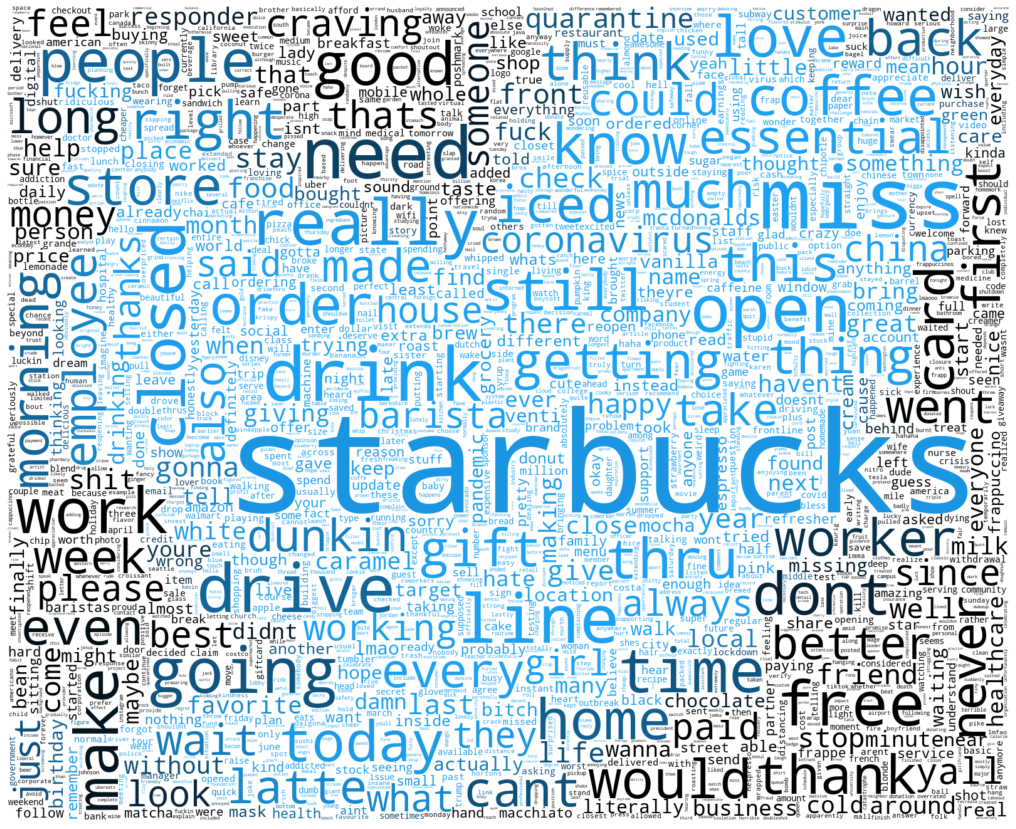

In [250]:
create_wordcloud(dalgona_preprocessed_kwd_sbucks, 'twitter-logo-4.png')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nathan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processing subdictionary: 1 of 48
Processing subdictionary: 2 of 48
Processing subdictionary: 3 of 48
Processing subdictionary: 4 of 48
Processing subdictionary: 5 of 48
Processing subdictionary: 6 of 48
Processing subdictionary: 7 of 48
Processing subdictionary: 8 of 48
Processing subdictionary: 9 of 48
Processing subdictionary: 10 of 48
Processing subdictionary: 11 of 48
Processing subdictionary: 12 of 48
Processing subdictionary: 13 of 48
Processing subdictionary: 14 of 48
Processing subdictionary: 15 of 48
Processing subdictionary: 16 of 48
Processing subdictionary: 17 of 48
Processing subdictionary: 18 of 48
Processing subdictionary: 19 of 48
Processing subdictionary: 20 of 48
Processing subdictionary: 21 of 48
Processing subdictionary: 22 of 48
Processing subdictionary: 23 of 48
Processing subdictionary: 24 of 48
Processing subdictionary: 25 of 48
Processing subdictionary: 26 of 48
Processing subdictionary: 27 of 48
Processing subdictionary: 28 of 48
Processing subdictionary: 29 

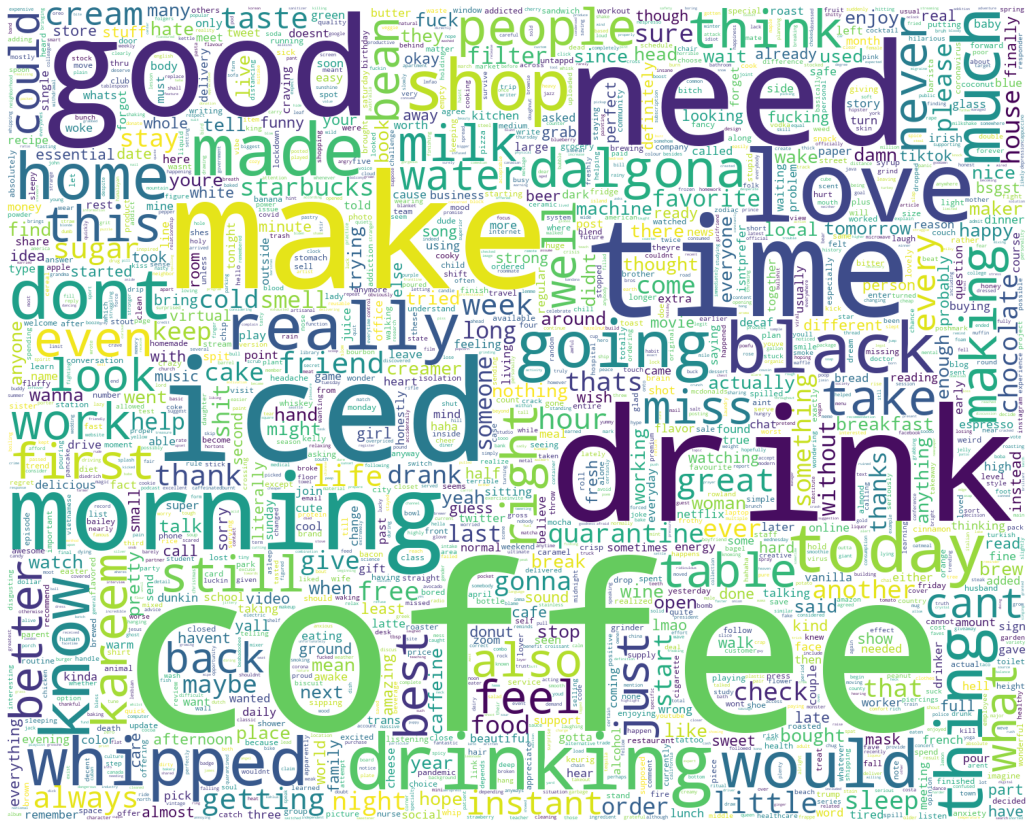

In [254]:
create_wordcloud(dalgona_preprocessed_kwd_coffee)

As you can see, the second wordcloud for 'coffee' identified 'dalgona' and 'whipped' (dalgona is a whipped coffee drink) as fairly prominent words, while the starbucks wordcloud did not. This shows that Starbucks can look into taking advantage of this trend.